In [1]:
import sys
sys.path.append('../code')
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import neo
import pandas as pd
import scipy
from externals.SpectralEvents import spectralevents as se

import mocap_functions, spike_train_functions, lfp_functions
from functools import partial
import pickle
import quantities as pq
import simnets
from sklearn.cluster import KMeans
import seaborn as sns


In [2]:
experiment_dict = sio.loadmat('../data/SPK20220308/task_data/eventsCB1_corrected2.mat')
ev_ex = experiment_dict['eventsCB1']

tgtON = ev_ex['tgtON_C'][0][0][0]
gocON = ev_ex['gocON_C'][0][0][0]
gocOFF = ev_ex['gocOFF_C'][0][0][0]

stmv = ev_ex['stmv_C'][0][0][0]
contact = ev_ex['contact_C'][0][0][0]
endhold = ev_ex['endhold_C'][0][0][0]

position = ev_ex['POSITION_C'][0][0][0]
layout = ev_ex['LAYOUT_C'][0][0][0]
objct = ev_ex['OBJECT_C'][0][0][0]
gripori = ev_ex['GRIPORI_C'][0][0][0]

gocON_all = ev_ex['gocON'][0][0][0]
tgtON_all = ev_ex['tgtON'][0][0][0]

reaction_time = stmv - gocON
reach_time = contact - stmv
grip_time = endhold - contact
move_time = contact - gocON


go_correct_mask = np.in1d(gocON_all, gocON)
tgt_correct_mask = np.in1d(tgtON_all, tgtON)

downsample_rate = 30
samp_freq = 1000

#Use neo module to load blackrock files
fpath = '../data/SPK20220308/task_data/SPKRH20220308_CB1_quiver4toyPKPK4Rotation_delay_001'
lfp_data_raw, lfp_times_raw = lfp_functions.load_ns6_analog(fpath, downsample_rate, from_ns6=False, save=False, channel_step=2)

In [3]:
eyes_path = f'../data/SPK20220308/motion_tracking/SpikeCam5_EYES_03-08-1557DLC_resnet50_DLC-eyesNov4shuffle1_40000_el.csv'

eyes_df = pd.read_csv(eyes_path, header=[1,2,3]).iloc[:,1:]
eyes_df.columns = ['_'.join(eyes_df.columns[idx]) for idx in range(len(eyes_df.columns))]
#eyes_df = cam_df.interpolate(method='cubic')

# Left eyes
eyes_df['lefteye_pupildiam_horiz'] = np.sqrt(
    np.square(eyes_df['lefteye_pupilinside_x'] - eyes_df['lefteye_pupiloutside_x']) + 
    np.square(eyes_df['lefteye_pupilinside_y'] - eyes_df['lefteye_pupiloutside_y']))

eyes_df['lefteye_pupildiam_vert'] = np.sqrt(
    np.square(eyes_df['lefteye_pupiltop_x'] - eyes_df['lefteye_pupilbottom_x']) + 
    np.square(eyes_df['lefteye_pupiltop_y'] - eyes_df['lefteye_pupilbottom_y']))

eyes_df['lefteye_pupildiam'] =  (eyes_df['lefteye_pupildiam_vert'] + eyes_df['lefteye_pupildiam_horiz']) / 2

# Right eyes
eyes_df['righteye_pupildiam_horiz'] = np.sqrt(
    np.square(eyes_df['righteye_pupilinside_x'] - eyes_df['righteye_pupiloutside_x']) + 
    np.square(eyes_df['righteye_pupilinside_y'] - eyes_df['righteye_pupiloutside_y']))

eyes_df['righteye_pupildiam_vert'] = np.sqrt(
    np.square(eyes_df['righteye_pupiltop_x'] - eyes_df['righteye_pupilbottom_x']) + 
    np.square(eyes_df['righteye_pupiltop_y'] - eyes_df['righteye_pupilbottom_y']))

eyes_df['righteye_pupildiam'] =  (eyes_df['righteye_pupildiam_vert'] + eyes_df['righteye_pupildiam_horiz']) / 2


In [4]:
# read python dict back from the file
cb_dict_file = open('../data/SPK20220308/task_data/cb_dict.pkl', 'rb')
cb_dict = pickle.load(cb_dict_file)
cb_dict_file.close()

cam_frames = cb_dict['cb1']['cam_frames']

In [5]:
# Find scale/timeshift between CB1 and CB2
cb2_align_ts = cb_dict['cb2']['experiment_dict']['df']['gocON_C'][0][0][0]
assert len(cb2_align_ts) == len(gocON) 
cb2_start, cb2_end = cb2_align_ts[0], cb2_align_ts[-1]

ts_shift = gocON[0] - cb2_start 
ts_scale = (cb2_end - cb2_start) / (gocON[-1] -  gocON[0])

unit_timestamps = cb_dict['cb1']['unit_timestamps'].copy()

# Shift and scale time stamps between the two machines
unit_timestamps_cb2 = cb_dict['cb2']['unit_timestamps'].copy()
unit_timestamps_cb2_corrected = dict()
for unit_idx, unit_ts in unit_timestamps_cb2.items():
    ts_corrected = (unit_ts + ts_shift * (pq.s)) / (ts_scale)
    unit_timestamps_cb2_corrected[unit_idx] = ts_corrected


unit_timestamps.update(unit_timestamps_cb2_corrected)
unit_timestamps_list = [ts for ts in unit_timestamps.values()]


In [6]:
st_offset = -1 # seconds
max_time = 2 # seconds
max_samples = int(max_time * samp_freq)
channel_idx = 50
#channel_idx = 10

# event_ts = gocON_all[~correct_mask]
event_ts = gocON_all
#event_ts = tgtON_all

pupil_cols = ['lefteye_pupildiam_horiz', 'lefteye_pupildiam_vert', 'lefteye_pupildiam',
              'righteye_pupildiam_horiz', 'righteye_pupildiam_vert', 'righteye_pupildiam']

lfp_data_list = list()
pupil_data_dict = {col: list() for col in pupil_cols}

for event_time in event_ts:
    tstart = event_time + st_offset
    tstop = tstart + max_time
    start_idx = np.argmin(np.abs(lfp_times_raw - tstart))
    stop_idx = start_idx + max_samples

    lfp_data_list.append(lfp_data_raw[channel_idx, start_idx:stop_idx])
    
    eyes_tstop = tstart + (max_time / 2)
    frame_mask = np.logical_and(cam_frames > (tstart * samp_freq), cam_frames < (eyes_tstop * samp_freq))
    frame_idx = np.flatnonzero(frame_mask) #Pull out indeces of valid frames
    
    for col in pupil_cols:
        pupil_data_dict[col].append(eyes_df[col].values[frame_idx])


pupil_data_df = pd.DataFrame(pupil_data_dict)
lfp_data = np.stack(lfp_data_list)


/home/ntolley/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


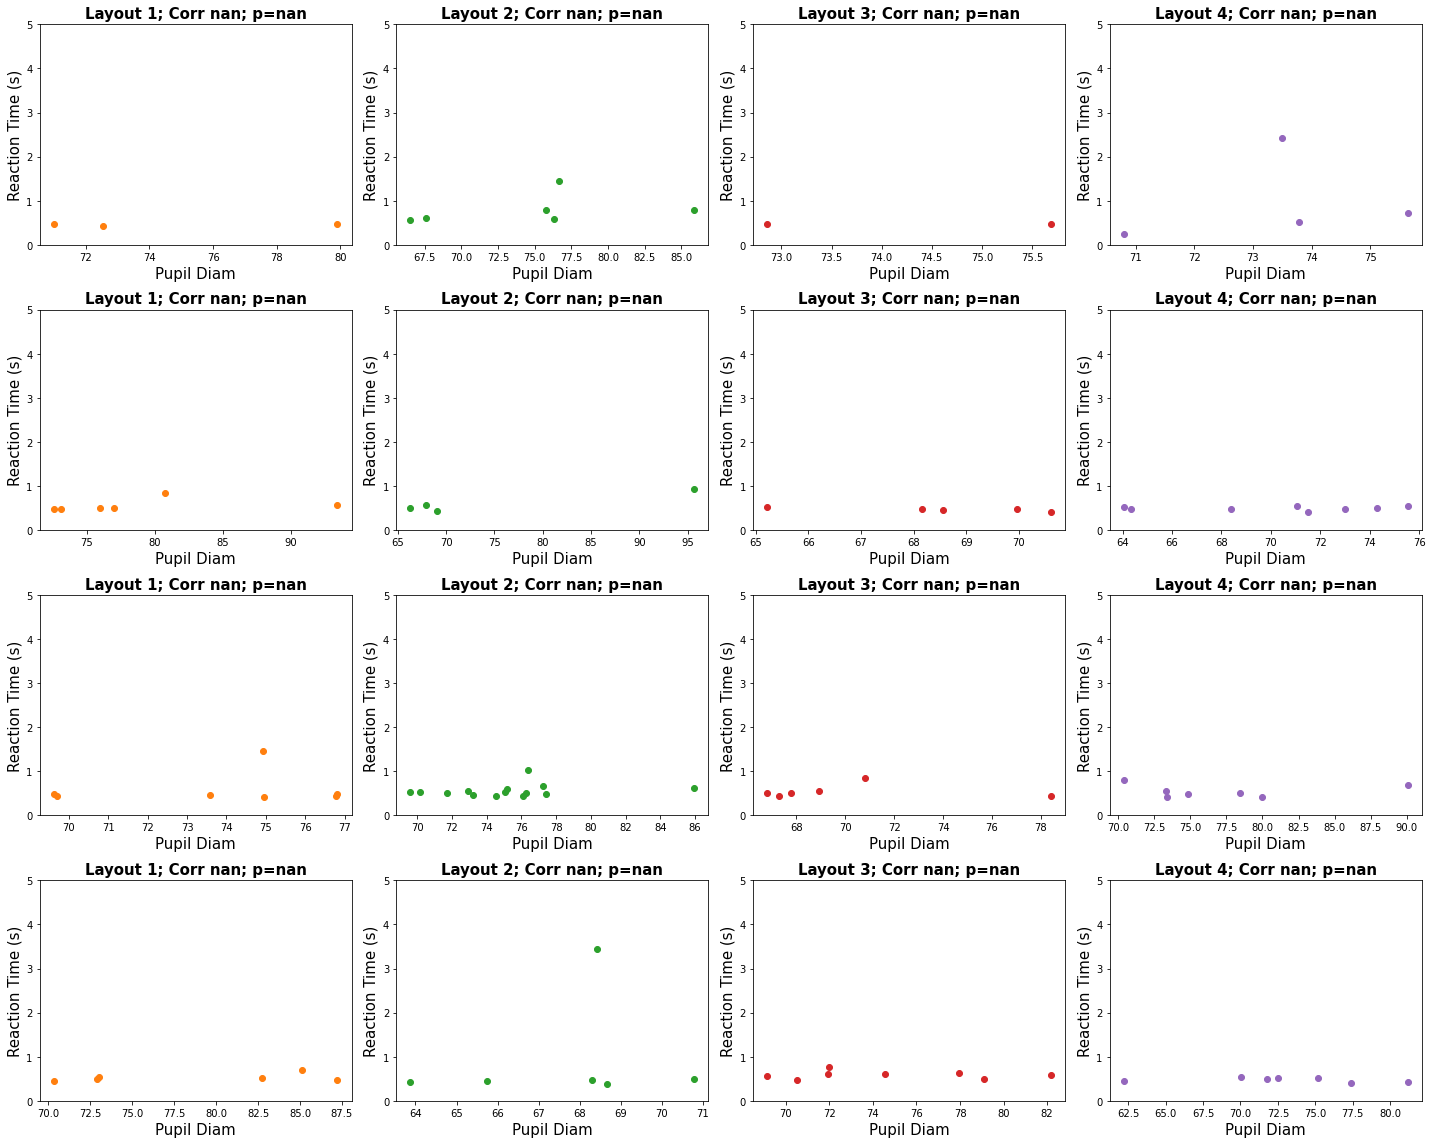

In [7]:
pupil_plot_data = pupil_data_df['righteye_pupildiam'].map(np.nanmedian).values
#pupil_plot_data = pupil_data_df['righteye_pupildiam'].map(np.diff).map(np.nanmedian).values


fontsize = 15
plt.figure(figsize=(20,16))
count = 1
for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(4,4,count)
        plot_mask = np.logical_and(position==position_idx, layout==layout_idx)
        plt.scatter(pupil_plot_data[go_correct_mask][plot_mask], 
                    reaction_time[plot_mask], color=f'C{layout_idx}')
        #plt.xscale('log')
        #plt.xlim(-4, 1.0)

        plt.ylim(0,5)

        corr = scipy.stats.spearmanr(pupil_plot_data[go_correct_mask][plot_mask],
                                    reach_time[plot_mask])
        plt.title(f'Layout {layout_idx}; Corr {np.round(corr[0], decimals=2)}; p={np.round(corr[1], decimals=2)}', fontsize = 15, fontweight='bold')
        plt.xlabel('Pupil Diam', fontsize = 15)
        plt.ylabel('Reaction Time (s)', fontsize = 15)
        plt.tight_layout()
        count = count+1

In [8]:
# power_samples = (500,1000) # range to calculate band power on
# power_list = np.array([lfp_functions.bandpower(
#     lfp_data[idx, power_samples[0]:power_samples[1]], fs=samp_freq, fmin=13, fmax=29) for 
#     idx in range(lfp_data.shape[0])])

pre_power_list = list()
post_power_list = list()

pre_samples = (0,1000)
post_samples = (1000,1500)

for idx in range(lfp_data.shape[0]):
    pre_power = lfp_functions.bandpower(
        lfp_data[idx, pre_samples[0]:pre_samples[1]], fs=samp_freq, fmin=13, fmax=29)
    
    pre_power_list.append(pre_power)
    
    post_power = lfp_functions.bandpower(
        lfp_data[idx, post_samples[0]:post_samples[1]], fs=samp_freq, fmin=13, fmax=29)
    
    post_power_list.append(post_power)
    
pre_power_list = np.array(pre_power_list)
post_power_list = np.array(post_power_list)

power_diff_list = pre_power_list - post_power_list

pre_power_sort = np.argsort(pre_power_list)[::-1]
post_power_sort = np.argsort(post_power_list)[::-1]
power_diff_sort = np.argsort(power_diff_list)[::-1]



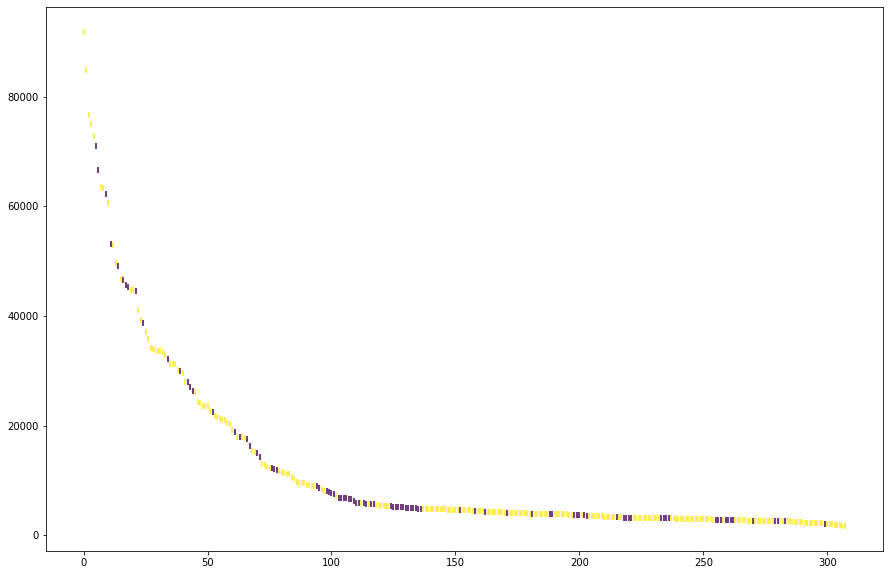

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(list(range(len(pre_power_sort))), pre_power_list[pre_power_sort], c=go_correct_mask, marker='|')

/home/ntolley/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


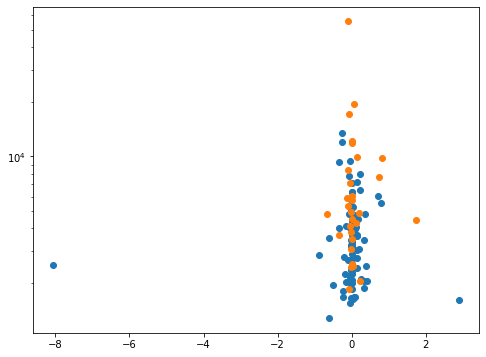

In [34]:
pupil_plot_data = pupil_data_df['righteye_pupildiam_vert'].map(np.diff).map(np.nanmedian).values
#pupil_plot_data = pupil_data_df['lefteye_pupildiam'].map(np.nanmedian).values

pupil_sort = np.argsort(pupil_plot_data)[::-1]

plt.figure(figsize=(8,6))
plt.scatter(pupil_plot_data[go_correct_mask], post_power_list[go_correct_mask])
plt.scatter(pupil_plot_data[~go_correct_mask], post_power_list[~go_correct_mask])


plt.yscale('log')

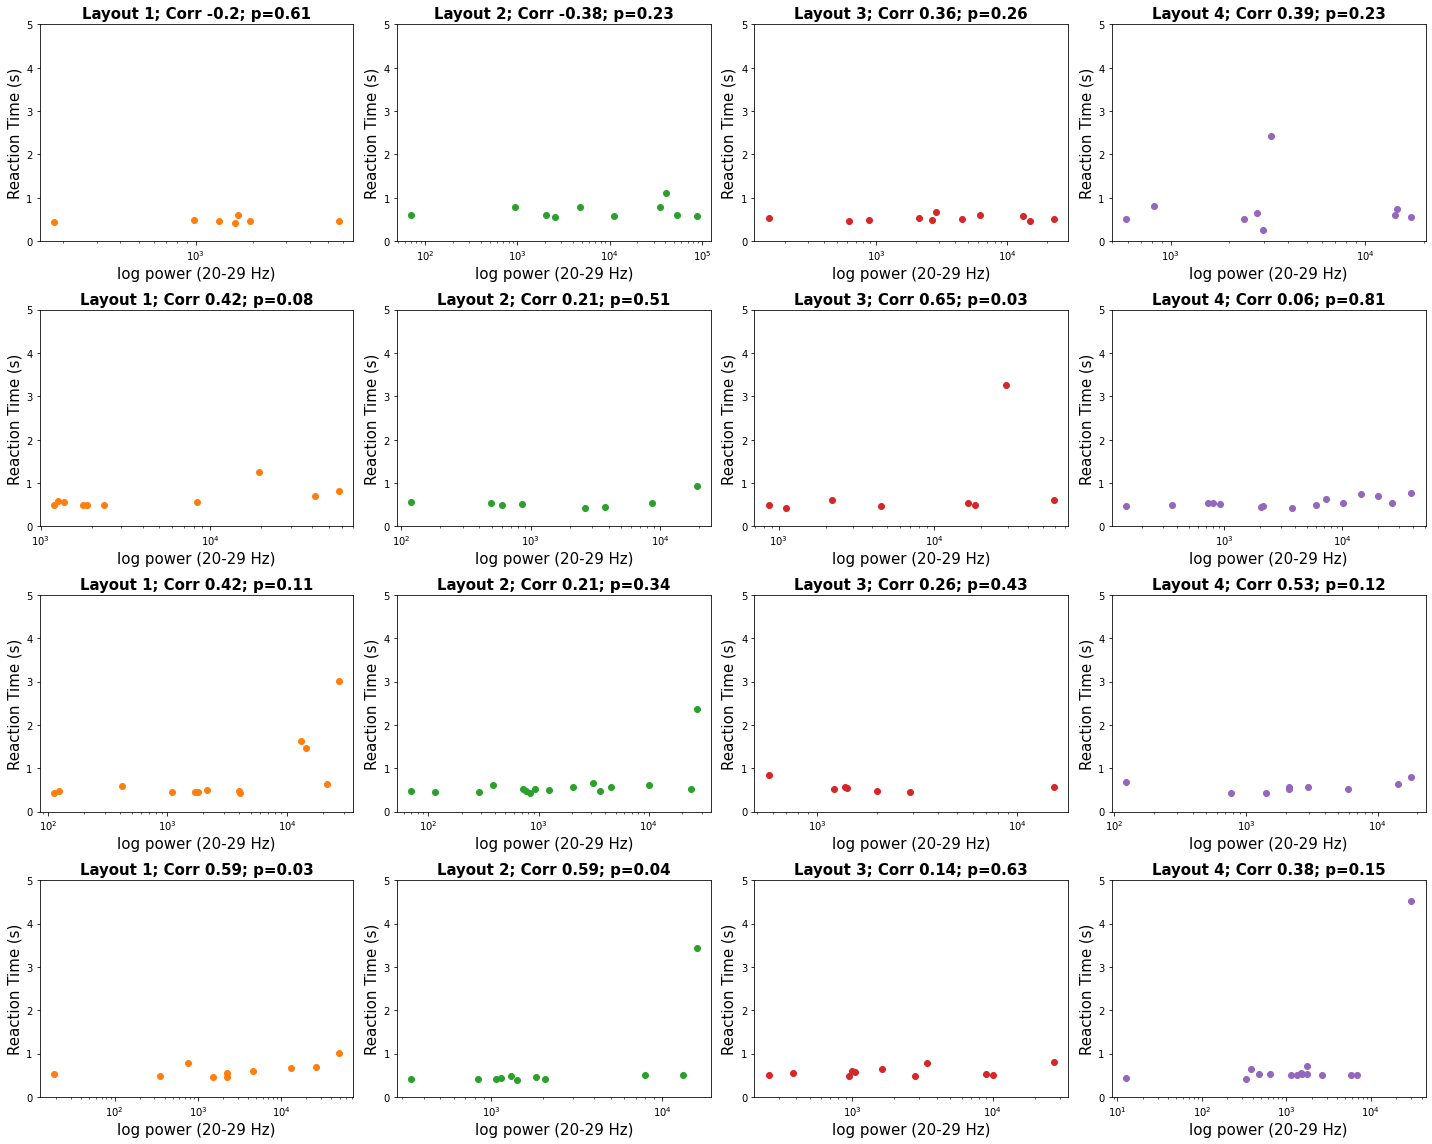

In [9]:
fontsize = 15
plt.figure(figsize=(20,16))
count = 1
for position_idx in range(1,5):
    for layout_idx in range(1,5):
        plt.subplot(4,4,count)
        plot_mask = np.logical_and(position==position_idx, layout==layout_idx)
        plt.scatter(power_diff_list[go_correct_mask][plot_mask], 
                    reaction_time[plot_mask], color=f'C{layout_idx}')
        plt.xscale('log')
        #plt.xlim(30,10**4)

        plt.ylim(0,5)

        corr = scipy.stats.spearmanr(power_diff_list[go_correct_mask][plot_mask],
                                    reaction_time[plot_mask])
        plt.title(f'Layout {layout_idx}; Corr {np.round(corr[0], decimals=2)}; p={np.round(corr[1], decimals=2)}', fontsize = 15, fontweight='bold')
        plt.xlabel('log power (20-29 Hz)', fontsize = 15)
        plt.ylabel('Reaction Time (s)', fontsize = 15)
        plt.tight_layout()
        count = count+1

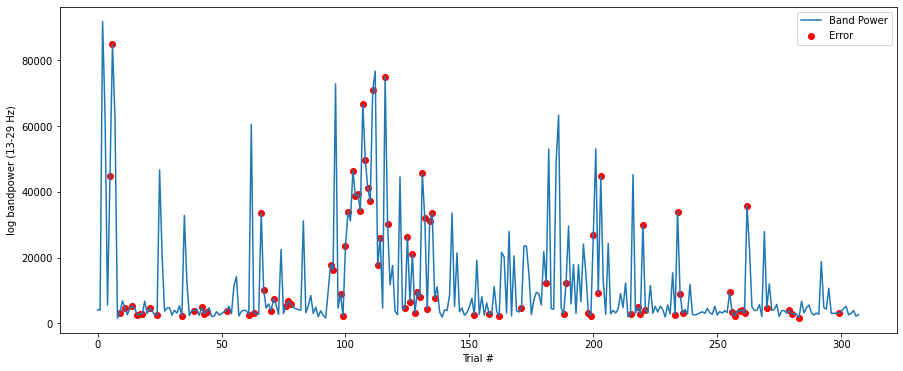

In [65]:
error_pos = np.where(~go_correct_mask)[0]
correct_pos = np.where(go_correct_mask)[0]


plt.figure(figsize=(15,6))
plt.plot(pre_power_list, label='Band Power')
plt.scatter(error_pos, pre_power_list[~go_correct_mask], color='r', label='Error',)
#plt.vlines(error_pos, ymin=np.min(power_list), ymax=np.max(power_list), color='r', linewidth=1)
#plt.yscale('log')
plt.xlabel('Trial #')
plt.ylabel('log bandpower (13-29 Hz)')
plt.legend()

Text(0, 0.5, 'Density')

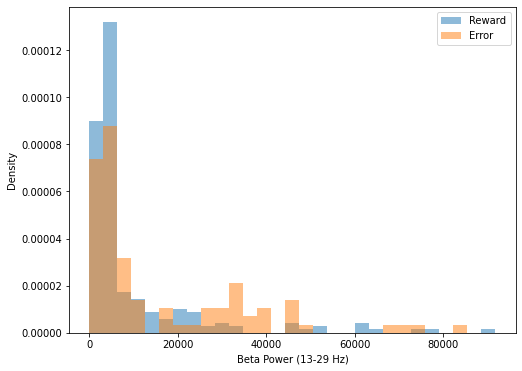

In [11]:
bins = np.linspace(0, np.max(pre_power_list), 30)

#correct_mask = tgt_correct_mask
correct_mask = go_correct_mask

plt.figure(figsize=(8,6))
_ = plt.hist(pre_power_list[correct_mask], density=True, alpha=0.5, bins=bins, label='Reward')
_ = plt.hist(pre_power_list[~correct_mask], density=True, alpha=0.5, bins=bins, label='Error')
plt.legend()
plt.xlabel('Beta Power (13-29 Hz)')
plt.ylabel('Density')
#plt.yscale('log')

In [38]:
# set parameters
freqs = list(range(1, 60 + 1))   # fequency values (Hz) over which to calculate TFR
#times = np.arange(n_times) / samp_freq  # seconds
event_band = [13, 29]  # beta band (Hz)
# event_band = [8, 12]  # alpha band (Hz)
# event_band = [13, 29]  # beta band (Hz)

thresh_FOM = 6.0  # factor-of-the-median threshold



In [39]:
times = np.linspace(0, lfp_data.shape[1] / samp_freq, lfp_data.shape[1])
tfrs = se.tfr(lfp_data[:,:], freqs, samp_freq)


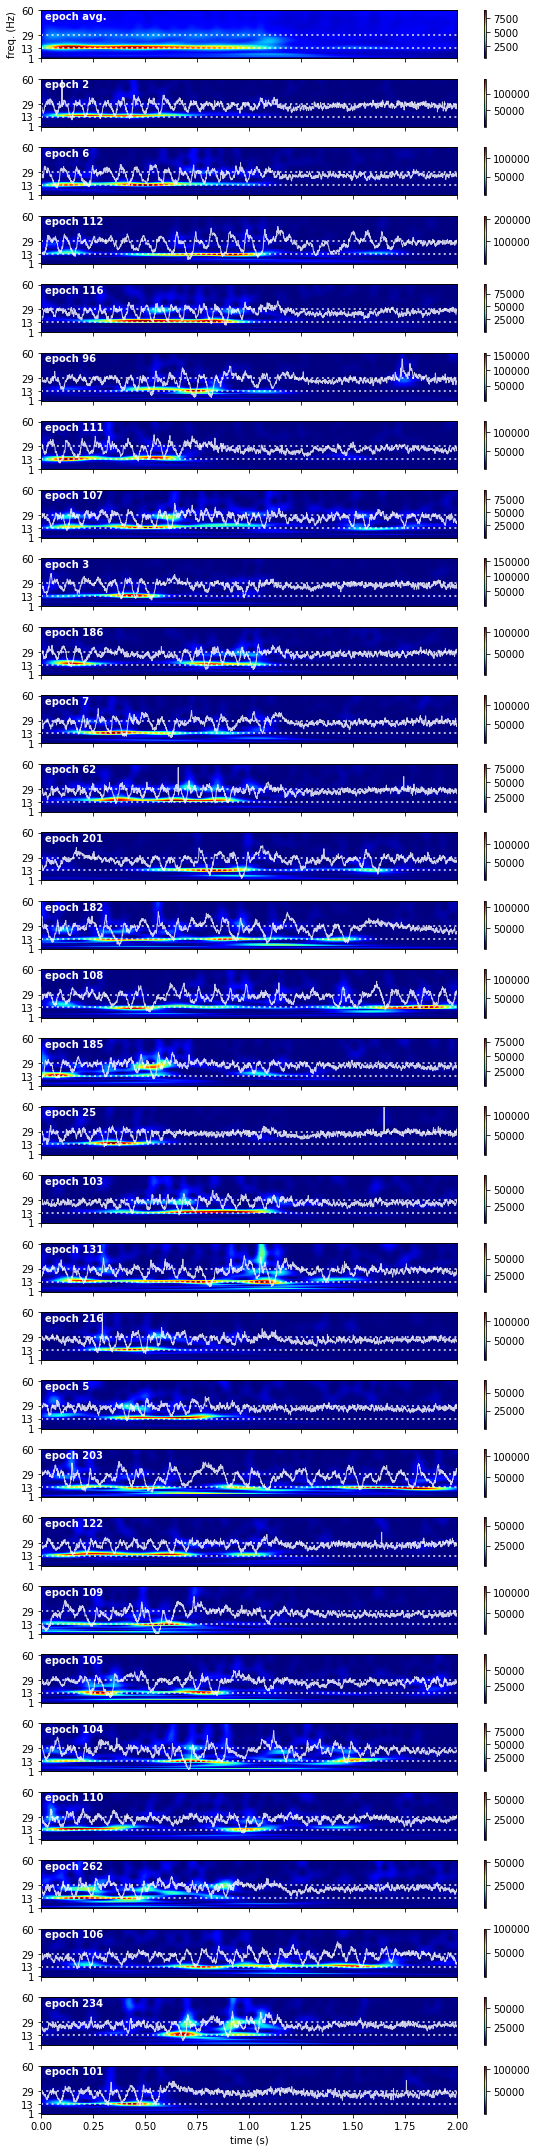

In [40]:
#example_trials = list(range(30))
example_trials = pre_power_sort[:30]


fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,30))

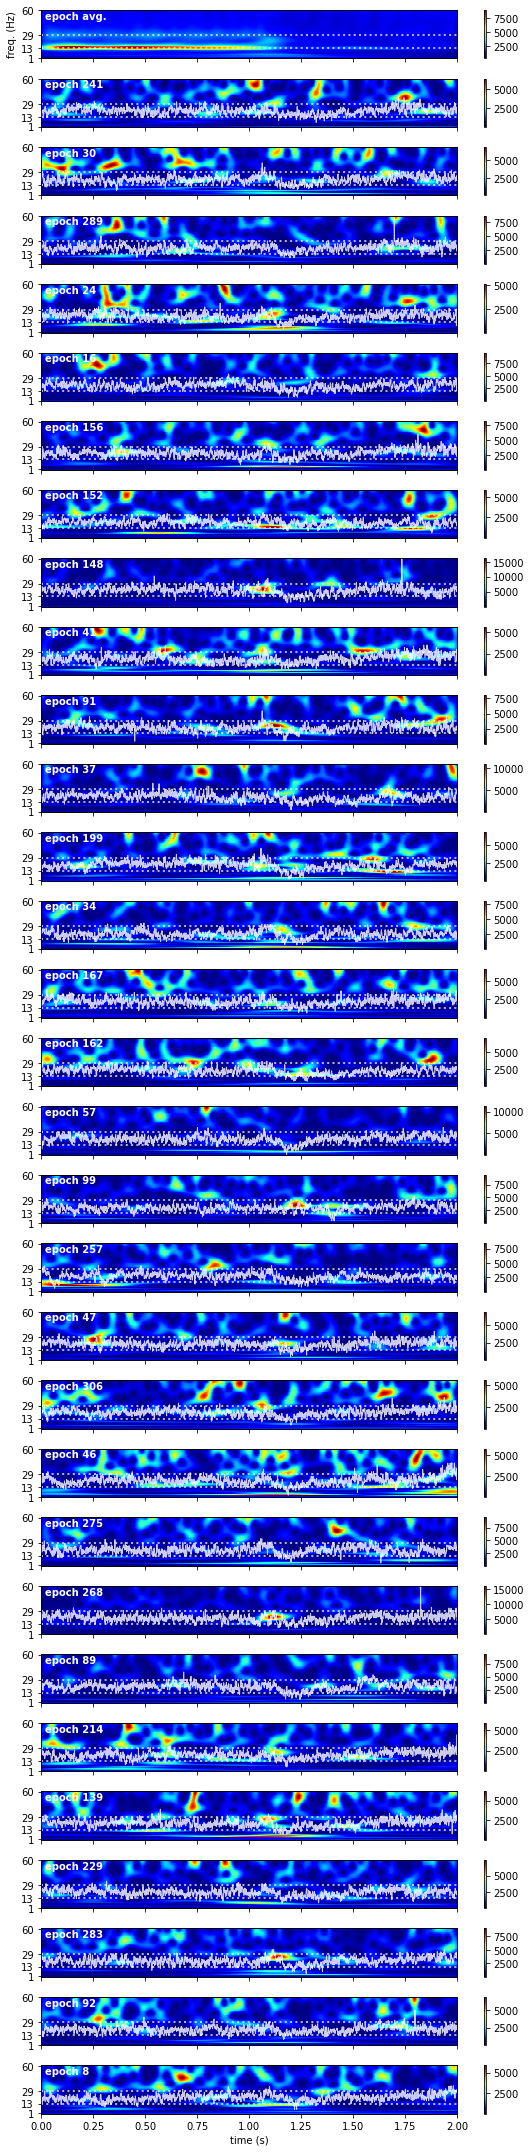

In [41]:
example_trials = pre_power_sort[-30:]


fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,30))

In [42]:
spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                             event_band=event_band, threshold_FOM=thresh_FOM)

In [43]:
pupil_event_data = pupil_data_df['righteye_pupildiam'].map(np.nanmedian).values
#pupil_event_data = pupil_data_df['righteye_pupildiam'].map(np.diff).map(np.nanmedian).values


event_df_list = list()
for trial_idx, trial_events in enumerate(spec_events):
    for event_idx, event_dict in enumerate(trial_events):
        event_dict['Trial'] = trial_idx
        #event_dict['Reward'] = correct_mask[trial_idx]
        event_dict['Rec Time'] = event_ts[trial_idx]
        event_dict['Pupil'] = pupil_event_data[trial_idx]
        event_dict['Reward'] = go_correct_mask[trial_idx]

        # event_dict['Reaction Time'] = stmv[trial_idx] - gocON[trial_idx]
        # event_dict['Reach Time'] = contact[trial_idx] - stmv[trial_idx]
        # event_dict['Grip Time'] = endhold[trial_idx] - contact[trial_idx]

        # event_dict['object'] = objct[trial_idx]
        # event_dict['layout'] = layout[trial_idx]
        # event_dict['position'] = position[trial_idx]
        # event_dict['gripori'] = gripori[trial_idx]
        
        
        event_df_list.append(event_dict)




/home/ntolley/anaconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1119: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [44]:
event_df = pd.DataFrame(event_df_list)

In [45]:
event_df

,Peak Frequency,Lower Frequency Bound,Upper Frequency Bound,Frequency Span,Peak Time,Event Onset Time,Event Offset Time,Event Duration,Peak Power,Normalized Peak Power,Trial,Rec Time,Pupil,Reward
0,18,15,22,7,0.130065,0.057029,0.213107,0.156078,6980.286379,7.515599,1,38.910633,81.155393,True
1,18,15,23,8,0.618309,0.517259,0.697349,0.180090,5824.644263,6.271332,1,38.910633,81.155393,True
2,14,12,16,4,0.409205,0.076038,0.606303,0.530265,145752.530046,187.601556,2,51.314433,76.309887,True
3,15,13,18,5,0.954477,0.000000,1.092546,0.278139,19605.013440,23.652122,2,51.314433,76.309887,True
4,16,14,19,5,0.869435,0.000000,1.075538,0.414207,20273.804938,23.540492,2,51.314433,76.309887,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1041,16,13,19,6,1.801901,1.714857,1.873937,0.159080,7076.245333,8.216430,302,4034.514767,70.611125,True
1042,21,13,26,13,0.472236,0.417209,0.517259,0.100050,5516.987188,6.033956,302,4034.514767,70.611125,True
1043,23,18,28,10,1.067534,1.019510,1.117559,0.098049,9791.618144,11.168387,302,4034.514767,70.611125,True
1044,29,13,34,21,0.081041,0.039020,0.127064,0.088044,5731.145455,6.509166,304,4070.544433,NaN,True


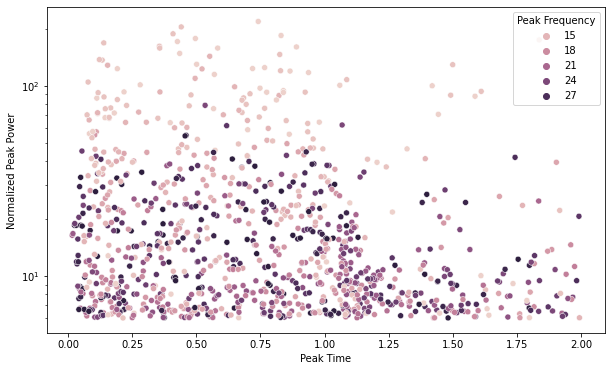

In [46]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=event_df, x='Peak Time', y='Normalized Peak Power', hue='Peak Frequency')
plt.yscale('log')
#plt.xscale('log')

<AxesSubplot: xlabel='Peak Power', ylabel='Frequency Span'>

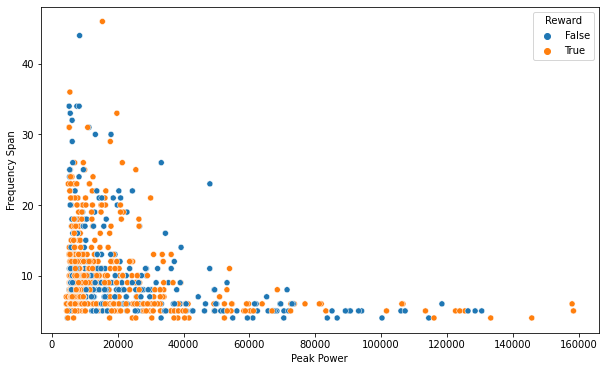

In [47]:
plt.figure(figsize=(10,6))

sns.scatterplot(data=event_df, x='Peak Power', y='Frequency Span', hue = 'Reward')

#plt.yscale('log')
#plt.xscale('log')


In [48]:
max_event_df = event_df.copy()
max_event_df = max_event_df[max_event_df['Peak Time'] < 1.0]
max_event_df['Count'] = max_event_df.groupby('Trial')['Peak Time'].count()
max_event_df = max_event_df.groupby('Trial').max('Peak Power')


<AxesSubplot: xlabel='Event Duration', ylabel='Density'>

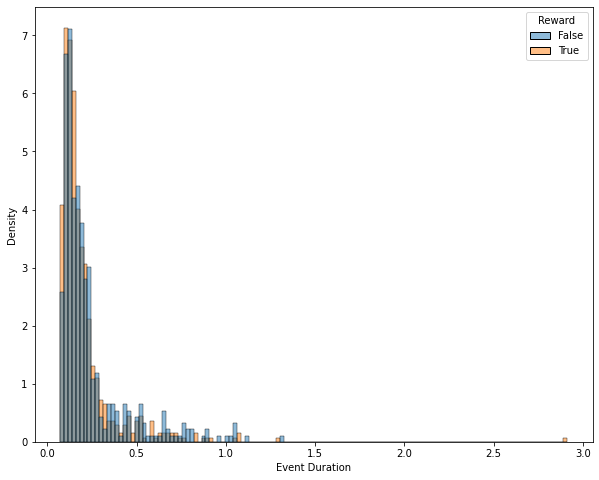

In [57]:
plt.figure(figsize=(10,8))
sns.histplot(event_df, x='Event Duration', hue='Reward', stat='density', common_norm=False)

<AxesSubplot: xlabel='Peak Power', ylabel='Density'>

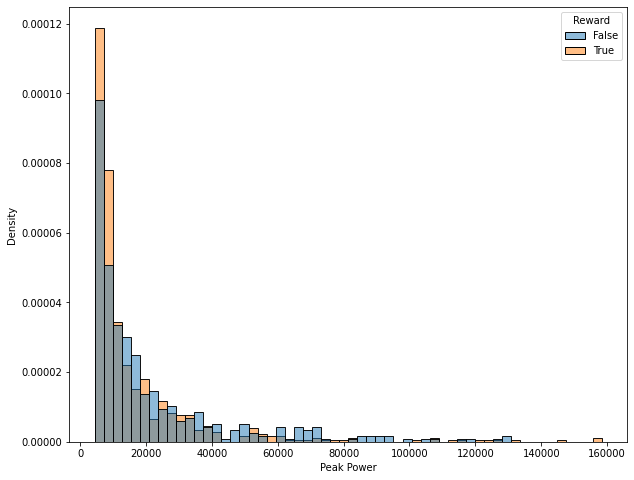

In [56]:
plt.figure(figsize=(10,8))
sns.histplot(event_df, x='Peak Power', hue='Reward', stat='density', common_norm=False)

In [35]:
power_threshold = 100_000
max_event_df = event_df.copy()
max_event_df = max_event_df[max_event_df['Peak Power'] < power_threshold]

max_event_df = max_event_df[max_event_df['Peak Time'] < 0.85]
max_event_df = max_event_df[max_event_df['Event Duration'] < 0.5]

max_event_df = max_event_df.groupby('Trial').max('Peak Power').reset_index()
#max_event_df = max_event_df[max_event_df['Normalized Peak Power'] < power_threshold]

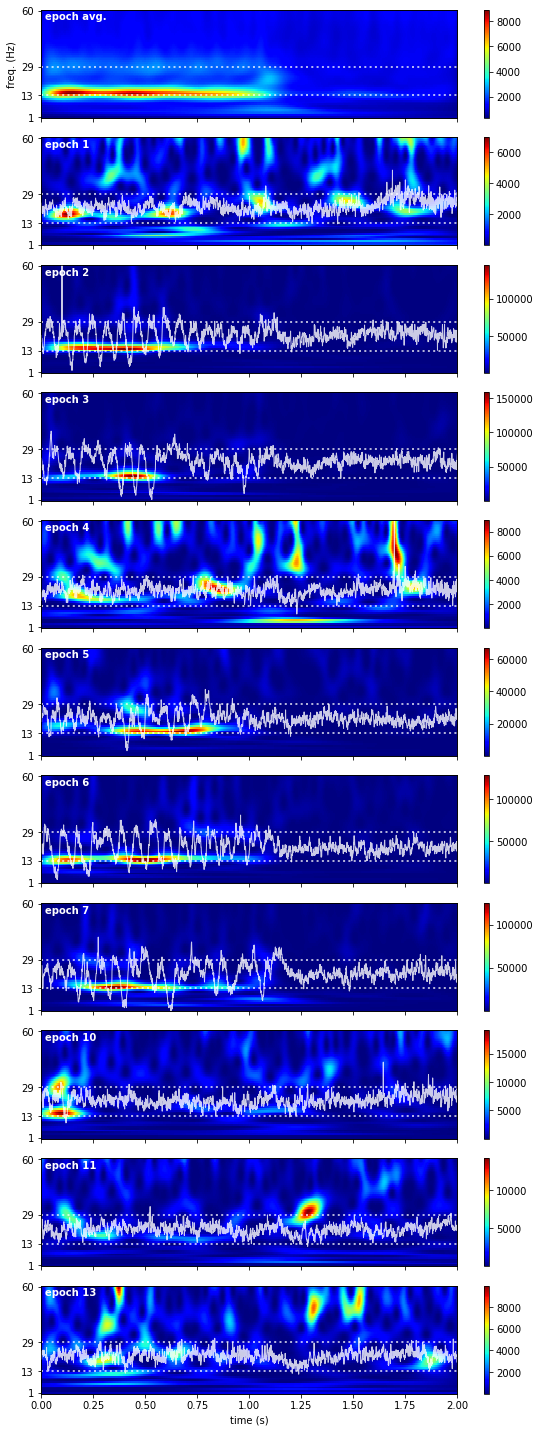

In [100]:
# Try plotting all trials including errors

example_trials = max_event_df['Trial'].values[:10]

fig = se.plot_avg_spectrogram(tfr=tfrs,
                              times=times,
                              freqs=freqs,
                              event_band=event_band,
                              timeseries=lfp_data,
                              example_epochs=example_trials,
                              figsize=(8,20))

In [59]:
# Calculate the actual time the Beta Event peak occurs during the full recording session
# max_event_times = max_event_df['Peak Time'].values + max_event_df['Rec Time'].values
# st_data = spike_train_functions.st_window_split(unit_timestamps_list, event_times=max_event_times * pq.s, wstart=-0.15 * pq.s, wstop=0.15 * pq.s)

#st_data = spike_train_functions.st_window_split(unit_timestamps_list, event_times=gocON_all * pq.s, wstart=-1 * pq.s, wstop=1 * pq.s)

max_event_times = event_df['Peak Time'].values + event_df['Rec Time'].values
st_data = spike_train_functions.st_window_split(unit_timestamps_list, event_times=max_event_times * pq.s, wstart=-0.15 * pq.s, wstop=0.15 * pq.s)


In [103]:
projection_args = {'n_components': 2, 'perplexity': 9, 'learning_rate': 5, 'random_state': 0}
st_args = (10,)
model = simnets.SIMNETS(st_dist='victor-purpura', unit_dist='correlation', projection='TSNE')
model.fit(st_data, st_args=st_args, projection_args=projection_args)


/home/ntolley/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'unit_data' of function 'SIMNETS._make_trial_func.<locals>.TrialSimilarityMatrix'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../SIMNETS-Python/simnets/simnets_.py", line 139:
        @numba.njit()
        def TrialSimilarityMatrix(unit_data, st_args=None):
        ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ntolley/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


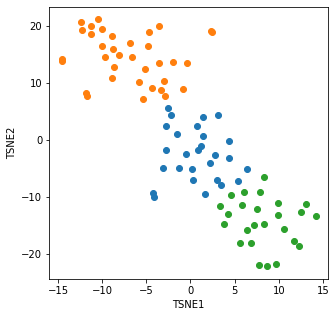

In [104]:
num_clusters = 3
cluster_pts = KMeans(n_clusters=num_clusters).fit_predict(model.points)

color_map = ['C0', 'C1', 'C2', 'C3', 'C4']
plt.figure(figsize=(5,5))
for cluster_idx in range(num_clusters):
    cluster_mask = cluster_pts == cluster_idx
    plt.scatter(model.points[cluster_mask, 0], model.points[cluster_mask, 1], color=color_map[cluster_idx])
    plt.xlabel('TSNE1')
    plt.ylabel('TSNE2')

KeyboardInterrupt: 

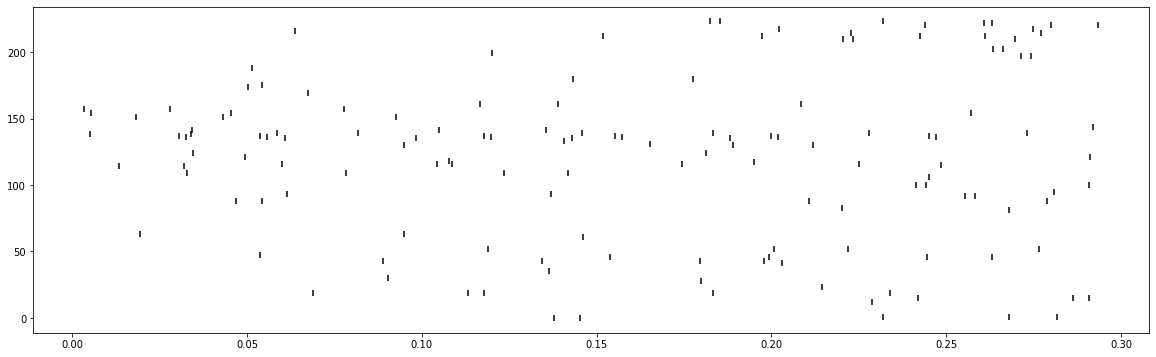

: 

In [60]:
# Plot trials
# error_sort = np.argsort(pre_power_list[error_pos])[::-1]
# correct_sort = np.argsort(pre_power_list[correct_pos])[::-1]

# error_sort = np.argsort(pupil_plot_data[error_pos])[::-1]
# correct_sort = np.argsort(pupil_plot_data[correct_pos])[::-1]

# correct_pos = np.where(max_event_df['Reward']==1)[0]
# error_pos = np.where(max_event_df['Reward']==0)[0]
# correct_sort = np.argsort(max_event_df[max_event_df['Reward']==1]['Normalized Peak Power'])[::-1]
# error_sort = np.argsort(max_event_df[max_event_df['Reward']==0]['Normalized Peak Power'])[::-1]

correct_pos = np.where(event_df['Reward']==1)[0]
error_pos = np.where(event_df['Reward']==0)[0]
correct_sort = np.argsort(event_df[event_df['Reward']==1]['Normalized Peak Power'])[::-1]
error_sort = np.argsort(event_df[event_df['Reward']==0]['Normalized Peak Power'])[::-1]



for plot_idx, unit_idx in enumerate(range(81)):
    plt.figure(figsize=(20,6))
    if plot_idx == 0:
        # counts = [len(unit_data) for unit_data in st_data[unit_idx]] 
        # trial_order = np.argsort(counts)
        # trial_order = pre_power_sort
        trial_order = np.concatenate([correct_pos[correct_sort], error_pos[error_sort]])

    for trial_idx in range(len(st_data[unit_idx])):
        plot_trial = trial_order[trial_idx]
        plot_data = st_data[unit_idx][plot_trial]
        height_data = np.repeat(trial_idx, len(plot_data)) 
        #plt.scatter(plot_data, height_data,color=color_map[cluster_pts[unit_idx]], marker='|')
        if plot_trial in error_pos:
            unit_color = 'r'
        else:
            unit_color = 'k'
        plt.scatter(plot_data, height_data,color=unit_color, marker='|')
    
    #plt.axvline(x=1.0, color='k', linewidth=5, alpha=0.5)

    plt.ylabel('Trial', fontsize=25)
    plt.xlabel('Time (s)', fontsize=25)
    plt.title(f'Unit {unit_idx}', fontsize=25)
    plt.tight_layout()
    plt.savefig(f'../figures/tmp/beta_sort_unit{unit_idx}.png')
    plt.close()

    

In [110]:
plt.figure(figsize=(10,10))
for plot_idx, trial_idx in enumerate([0, 2, 3, 4]):

    # Pull out spikes for specific trial across all neurons
    trial_data = [unit_data[trial_idx] for unit_data in st_data]
    trial_sort = pre_power_sort[go_correct_mask]
    
    if plot_idx == 0:
        counts = [len(unit_data) for unit_data in trial_data]
        unit_order = np.argsort(counts)

    plt.subplot(4,1, plot_idx + 1)
    for unit_idx in range(len(trial_data)):
        plot_unit = unit_order[unit_idx]
        plot_data = trial_data[plot_unit]
        height_data = np.repeat(unit_idx, len(plot_data))
        #plt.scatter(plot_data, height_data,color=color_map[cluster_pts[plot_unit]], marker='|')
    
    plt.ylabel('Unit', fontsize=15)
    plt.title(f'Trial {max_event_df["Trial"].values[trial_idx]}', fontsize=15)

plt.tight_layout()

NameError: name 'st_data' is not defined

<Figure size 720x720 with 0 Axes>

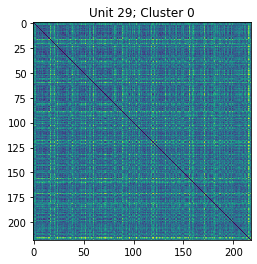

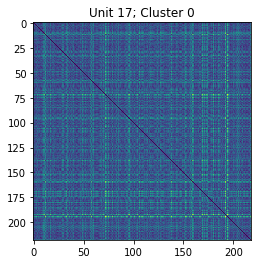

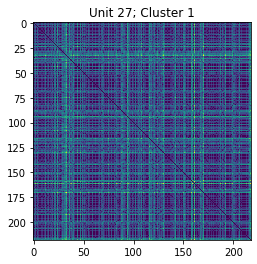

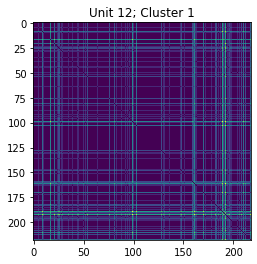

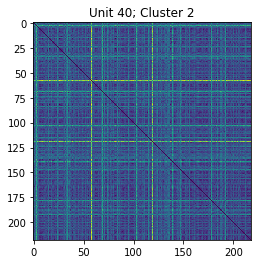

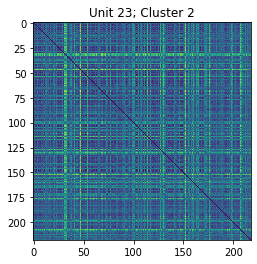

In [201]:
plot_units = [10, 5]

plot_clusters = [0, 1, 2]

unit_indices = list()
for cluster_idx in plot_clusters:
    for plot_unit in plot_units:
        cluster_units = np.where(cluster_pts == cluster_idx)[0]
        unit_idx = cluster_units[plot_unit]
        unit_indices.append(unit_idx)
        trial_sim = model.trial_sim[unit_idx].reshape(model.num_trials, model.num_trials)
        plt.figure()
        plt.imshow(trial_sim)
        plt.title(f'Unit {unit_idx}; Cluster {cluster_idx}')
       
